In [1]:
import _cffi_backend
import numpy as np
from datasets import load_dataset, load_from_disk
from pixel_datasets.dataset_transformations import SyntheticDatasetTransform, SimpleTorchTransform  
from pixel_datasets.pixel_dataset_generator import PretrainingDataset
from pixel_datasets.utils.utils import plot_arrays
from pixel_datasets.glue_dataset_generator import GlueDatasetForPixel
import wandb
from PIL import Image
from pixel_datasets.utils.squad_utils import (
    generate_pixel_mask_from_recangles,
    merge_rectangle_lines,
    convert_pixel_mask_to_patch_mask,
)

In [38]:
import cv2
import numpy as np
from PIL import Image

image = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/23.png")
image = np.array(image)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel = np.ones((5, 5), np.uint8)
grad = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)

_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

# using RETR_EXTERNAL instead of RETR_CCOMP
contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#For opencv 3+ comment the previous line and uncomment the following line
#_, contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

mask = np.zeros(bw.shape, dtype=np.uint8)

for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

    if r > 0.45 and w > 8 and h > 8:
        cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

In [13]:
cv2.boundingRect(c)

(0, 0, 368, 81)

In [55]:
summed = np.sum(connected / 255, axis=1)
np.max(np.where(summed > 32)[0])

162

In [ ]:
import pytesseract
ocred_image = pytesseract.image_to_data(
        np.array(image), lang="eng", output_type=pytesseract.Output.DICT
    )
ocred_image

In [9]:
print(" ".join(ocred_image["text"]))

    “T Hele are to give Notice, that there isrun away from a W eft-Country Gentle-  man, a Black, he is a handfome gentile young Fellow as any of his Kind :  Any Perfon or Perfons who fhall apprehend and fecure the faid Black, fo as that he  may be got back to the. Owner, let them come to Mr. Colin Mackenzie Gold-Smith  in the Parliament-Clofs in Edinburgh, or to Mr. Patrick Hufton Merchant in Glafgow,  and they fhall have Three Guineas Reward, and Charges born them, and the  Gentleman's Kindnefs befides. _ oa 259 Paths BB rus See pect    ae


In [2]:
rng = np.random.RandomState(2)
wandb.init(config="/home/knf792/PycharmProjects/pixel-2/configs/squad_config.yaml", mode="disabled")
transform = SyntheticDatasetTransform(wandb.config, rng=rng)
train_dataset = SquadDatasetForPixel(config=wandb.config, transform=transform, rng=rng)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


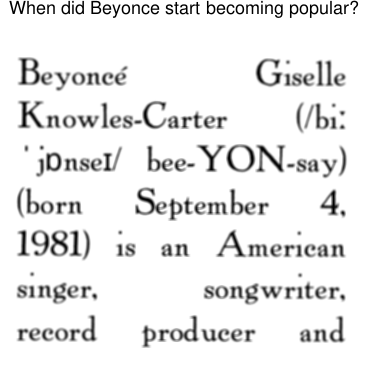

In [199]:
iterator = train_dataset.__iter__()
sample = iterator.__next__()
im = (sample["pixel_values"].numpy()).astype("float32").transpose(1, 2, 0)
mask = sample["label_mask"].numpy().astype("uint8")
mask = np.kron(mask, np.ones((16, 16)))
im[mask == 1] = im[mask == 1] - 60
im = np.clip(im, 0, 255).astype("uint8")
image = Image.fromarray(im)
image

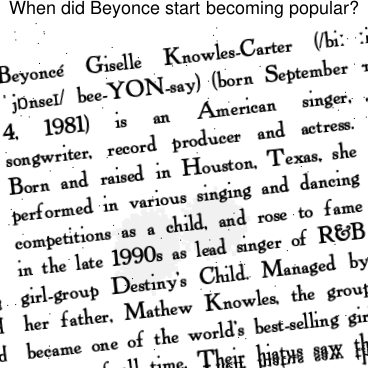

In [227]:
context = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historical_squad_just_context.png")
context = np.asarray(context)
mask = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historica_squad_just_mask.png")
mask = np.asarray(mask)

question = im[: im.shape[0] - context.shape[0], :]



wandb.config.update({"rotation_max_degrees": 10}, allow_val_change=True)
wandb.config.update({"rotation_probability": 1}, allow_val_change=True)

transform = SyntheticDatasetTransform(wandb.config, rng=rng)
context, mask = transform(context.copy(), mask)
context = context.numpy().astype("uint8").transpose(1, 2, 0)

scan = np.concatenate([question, context], axis=0)
mask = np.concatenate([np.zeros((question.shape[0], mask.shape[1])), mask], axis=0)
scan = Image.fromarray(scan)
scan

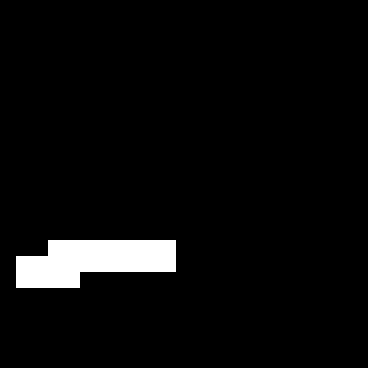

In [228]:
pixel_mask = convert_pixel_mask_to_patch_mask(np.asarray(mask),
                wandb.config.patch_base_size[0],
                wandb.config.mask_patching_tolerance,)
pixel_mask = np.kron(pixel_mask, np.ones((16, 16)))
pixel_mask = Image.fromarray(pixel_mask.astype("uint8") * 255)
pixel_mask


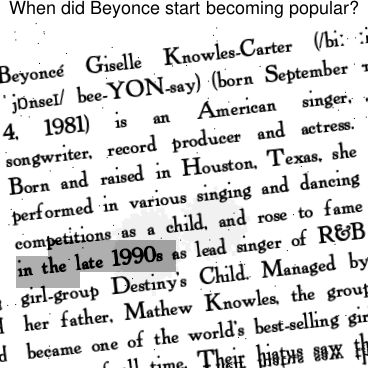

In [229]:
im = np.asarray(scan).astype("float32")
mask = np.asarray(pixel_mask)
im[mask == 255] = im[mask == 255] - 80 

im = np.clip(im, 0, 255).astype("uint8")
image = Image.fromarray(im)
image


In [230]:
image.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/visual_historical_squad_final.png")

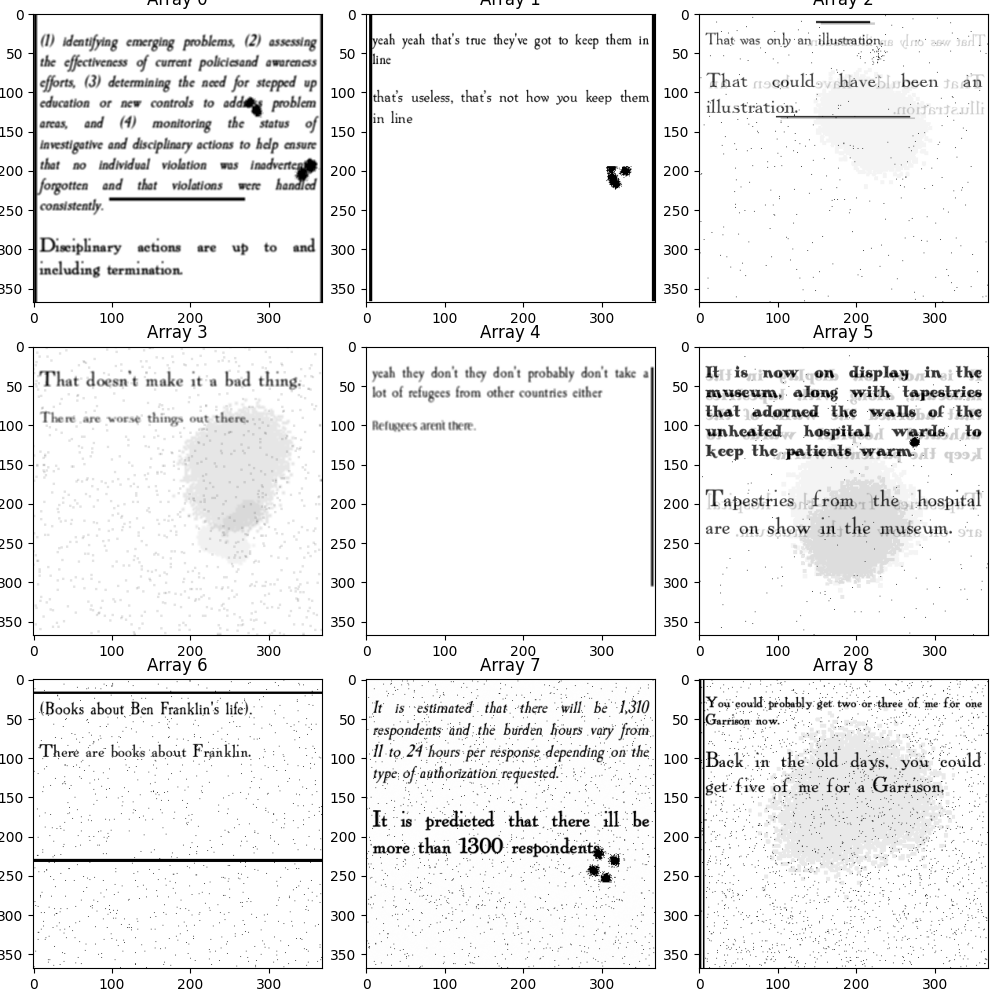

In [4]:
figures = []
for i in range(3):
    counter = 0
    for j in np.random.randint(0, len(train_dataset), 3):
        batch = train_dataset[int(j)]
        im = batch["pixel_values"].numpy().astype("uint8").transpose(1, 2, 0)
        
        figures.append(im)
        counter += 1

im = plot_arrays(figures)
im

In [27]:
wandb.init(config="/home/knf792/PycharmProjects/pixel-2/configs/pretraining_config.yaml", mode="disabled")
wandb.config.update({"font_list_path": "pixel_datasets/fonts/antique_fonts.csv"}, allow_val_change=True)
text_dataset = load_dataset("wikipedia", "20220301.en").select(range(1000))


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:randomizing dataset with worker id=0 and epoch=0


INFO:root:randomizing dataset with worker id=0 and epoch=1
INFO:root:randomizing dataset with worker id=0 and epoch=2


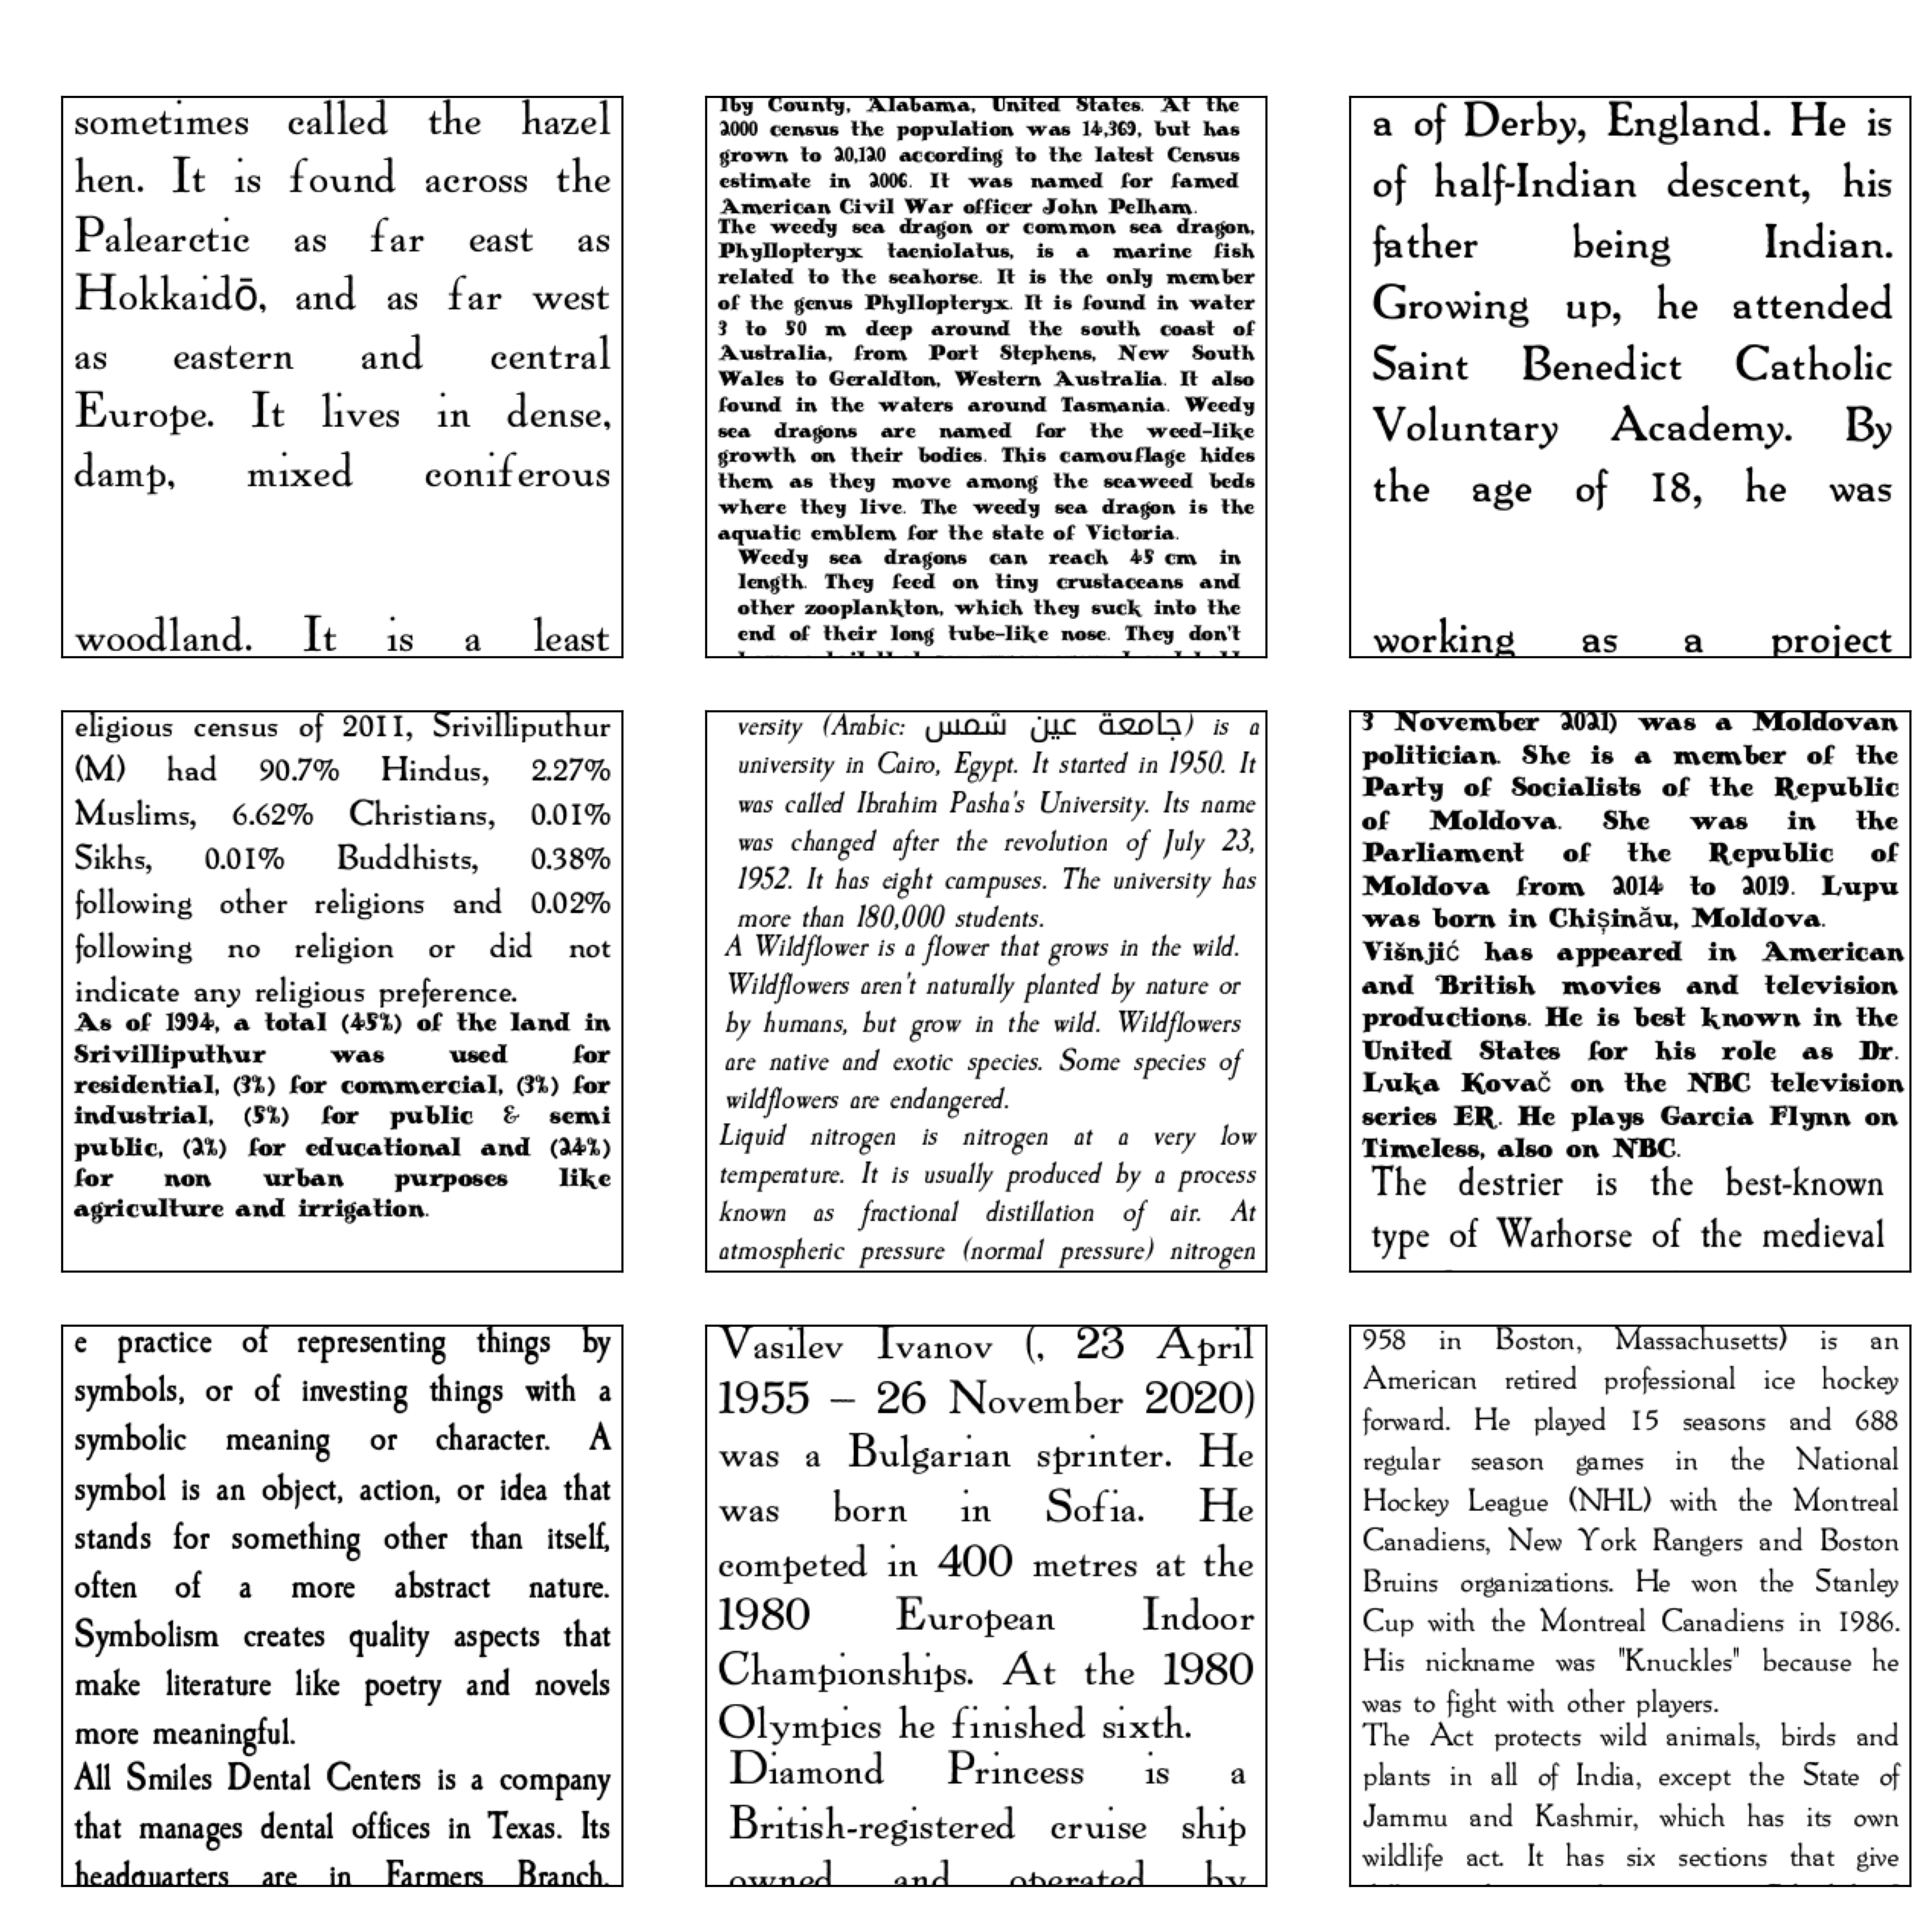

In [4]:
rng = np.random.RandomState(21)

transform = SimpleTorchTransform(wandb.config, rng=rng)
train_dataset = PretrainingDataset(wandb.config, text_dataset["train"], transform, rng=rng)

figures = []
for i in range(3):
    train_dataset.set_epoch(i)
    counter = 0
    for batch in train_dataset:
        if counter == 3:
            break
        im = (batch["pixel_values"].numpy() * 255).astype("uint8").transpose(1, 2, 0)
        
        mask = batch["patch_mask"].numpy().reshape(23, 23)
        mask = np.kron(mask, np.ones((16, 16))).astype("uint8")
        
        # im = im * (1 - mask[..., None])
        figures.append(im)
        counter += 1

im = plot_arrays(figures)
im

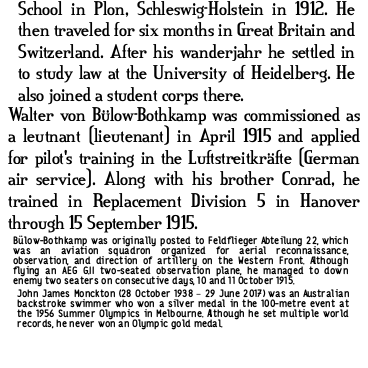

In [2]:

image = Image.open("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/samples/synthetics_no_noise_10.png").copy().convert("RGB")
image

In [61]:
image_cropped = np.asarray(image).copy()
image_cropped[103:] = 255
image_cropped = Image.fromarray(image_cropped)
image_cropped.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/samples/synthetics_no_noise_10_cropped.png")

In [72]:
np.asarray(image).dtype

dtype('uint8')

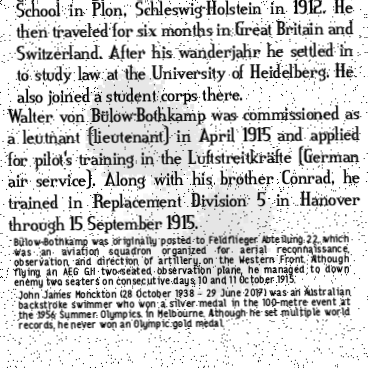

In [6]:
rng = np.random.RandomState(12345)
wandb.init(config="/home/knf792/PycharmProjects/pixel-2/configs/pretraining_config.yaml", mode="disabled")
transform = SyntheticDatasetTransform(wandb.config, rng=rng)

with_augs = transform(np.asarray(image).copy()[:,:,0])
with_augs = with_augs.numpy().astype("uint8").transpose(1, 2, 0) 
with_augs = Image.fromarray(with_augs)
with_augs

In [98]:
with_augs.save("/home/knf792/PycharmProjects/pixel-2/pixel_datasets/results/samples/pretraining_sample_with_augmentations.png")

In [5]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset("glue", "mrpc")

Found cached dataset glue (/home/knf792/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
np.mean(dataset["train"]["label"])

0.6744820065430752

In [102]:
im = Image.open("/projects/copenlu/data/nadav/pixel/runaways_scans/0443.png")
im.save("evaluations/runaway_target_1.png")

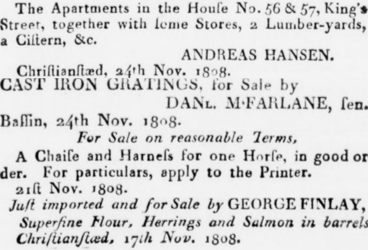

In [109]:
Image.open("/projects/copenlu/data/nadav/pixel/data/real_scans/train/The_St._Croix_Gazette_(1808-1813)_-_1808-11-28_page_2_12.png")

In [119]:
image_paths = ['/projects/copenlu/data/nadav/pixel/data/real_scans/train/Dansk_Vestindisk_Regierings_Avis_(1802-1807)_-_1804-07-09_page_3_11.png',
               '/projects/copenlu/data/nadav/pixel/data/real_scans/train/Dansk_Vestindisk_Regierings_Avis_(1802-1807)_-_1804-06-07_page_0_8.png',
'/projects/copenlu/data/nadav/pixel/data/real_scans/train/The_St._Croix_Gazette_(1808-1813)_-_1808-11-28_page_2_12.png',
'/projects/copenlu/data/nadav/pixel/data/real_scans/train/The_St._Croix_Gazette_(1808-1813)_-_1809-02-10_page_2_12.png',

'/projects/copenlu/data/nadav/pixel/data/real_scans/train/The_St._Croix_Gazette_(1808-1813)_-_1811-05-17_page_3_11.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Curacao_Gazette_And_Commercial_Advertiser_published_as_THE_CURACAO_GAZETTE.___December_11_1812_(1_of_1)_page_3_11.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Bermudian._A_Commercial_Political_and_Literary_Journal_published_as_THE_BERMUDIAN.___January_31_1821_(1_of_1)_page_2_37.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Saint_Lucia_Gazette_published_as_Saint_Lucia_GAZETTE.___October_29_1834_(1_of_1)_page_2_75.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Jamaica_Watchman_published_as_Jamaica_Watchman.___August_25_1832_(1_of_1)_page_2_8.png',
                ]

runaway_paths = ['/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Royal_Gazette_published_as_ROYAL_GAZETTE.___July_13_1822_(1_of_1)_page_12_17.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Royal_Gazette_published_as_ROYAL_GAZETTE.___July_13_1822_(1_of_1)_page_8_5.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Royal_Gazette_published_as_ROYAL_GAZETTE.___September_20_1823_(1_of_1)_page_5_13.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/St._Georges_Chronicle_and_Grenada_Gazette_published_as_ST._GEORGE_CHRONICLE___December_31_1836_(1_of_1)_page_1_14.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Grenada_Free_Press_and_Weekly_Gazette_published_as_The_Grenada_Free_Press___December_7_1831_(1_of_1)_page_2_20.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Royal_Gazette_published_as_ROYAL_GAZETTE.___June_30_1781_(1_of_1)_page_2_8.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Royal_Gazette_published_as_ROYAL_GAZETTE.___October_12_1822_(1_of_1)_page_9_14.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Grenada_Free_Press_and_Weekly_Gazette_published_as_GRENADA_FREE_PRESS___September_17_1828_(1_of_1)_page_0_23.png',
'/projects/copenlu/data/nadav/pixel/data/Caribbean_scans_dataset/train/Royal_Gazette_published_as_ROYAL_GAZETTE.___September_20_1823_(1_of_1)_page_5_10.png']

In [133]:
from PIL import Image
from pixel_datasets.utils.utils import plot_arrays
import numpy as np

images = []
for i, path in enumerate(image_paths):
    image = Image.open(path)
    image.save(f"evaluations/runaways_semantic_search_{i}.png")


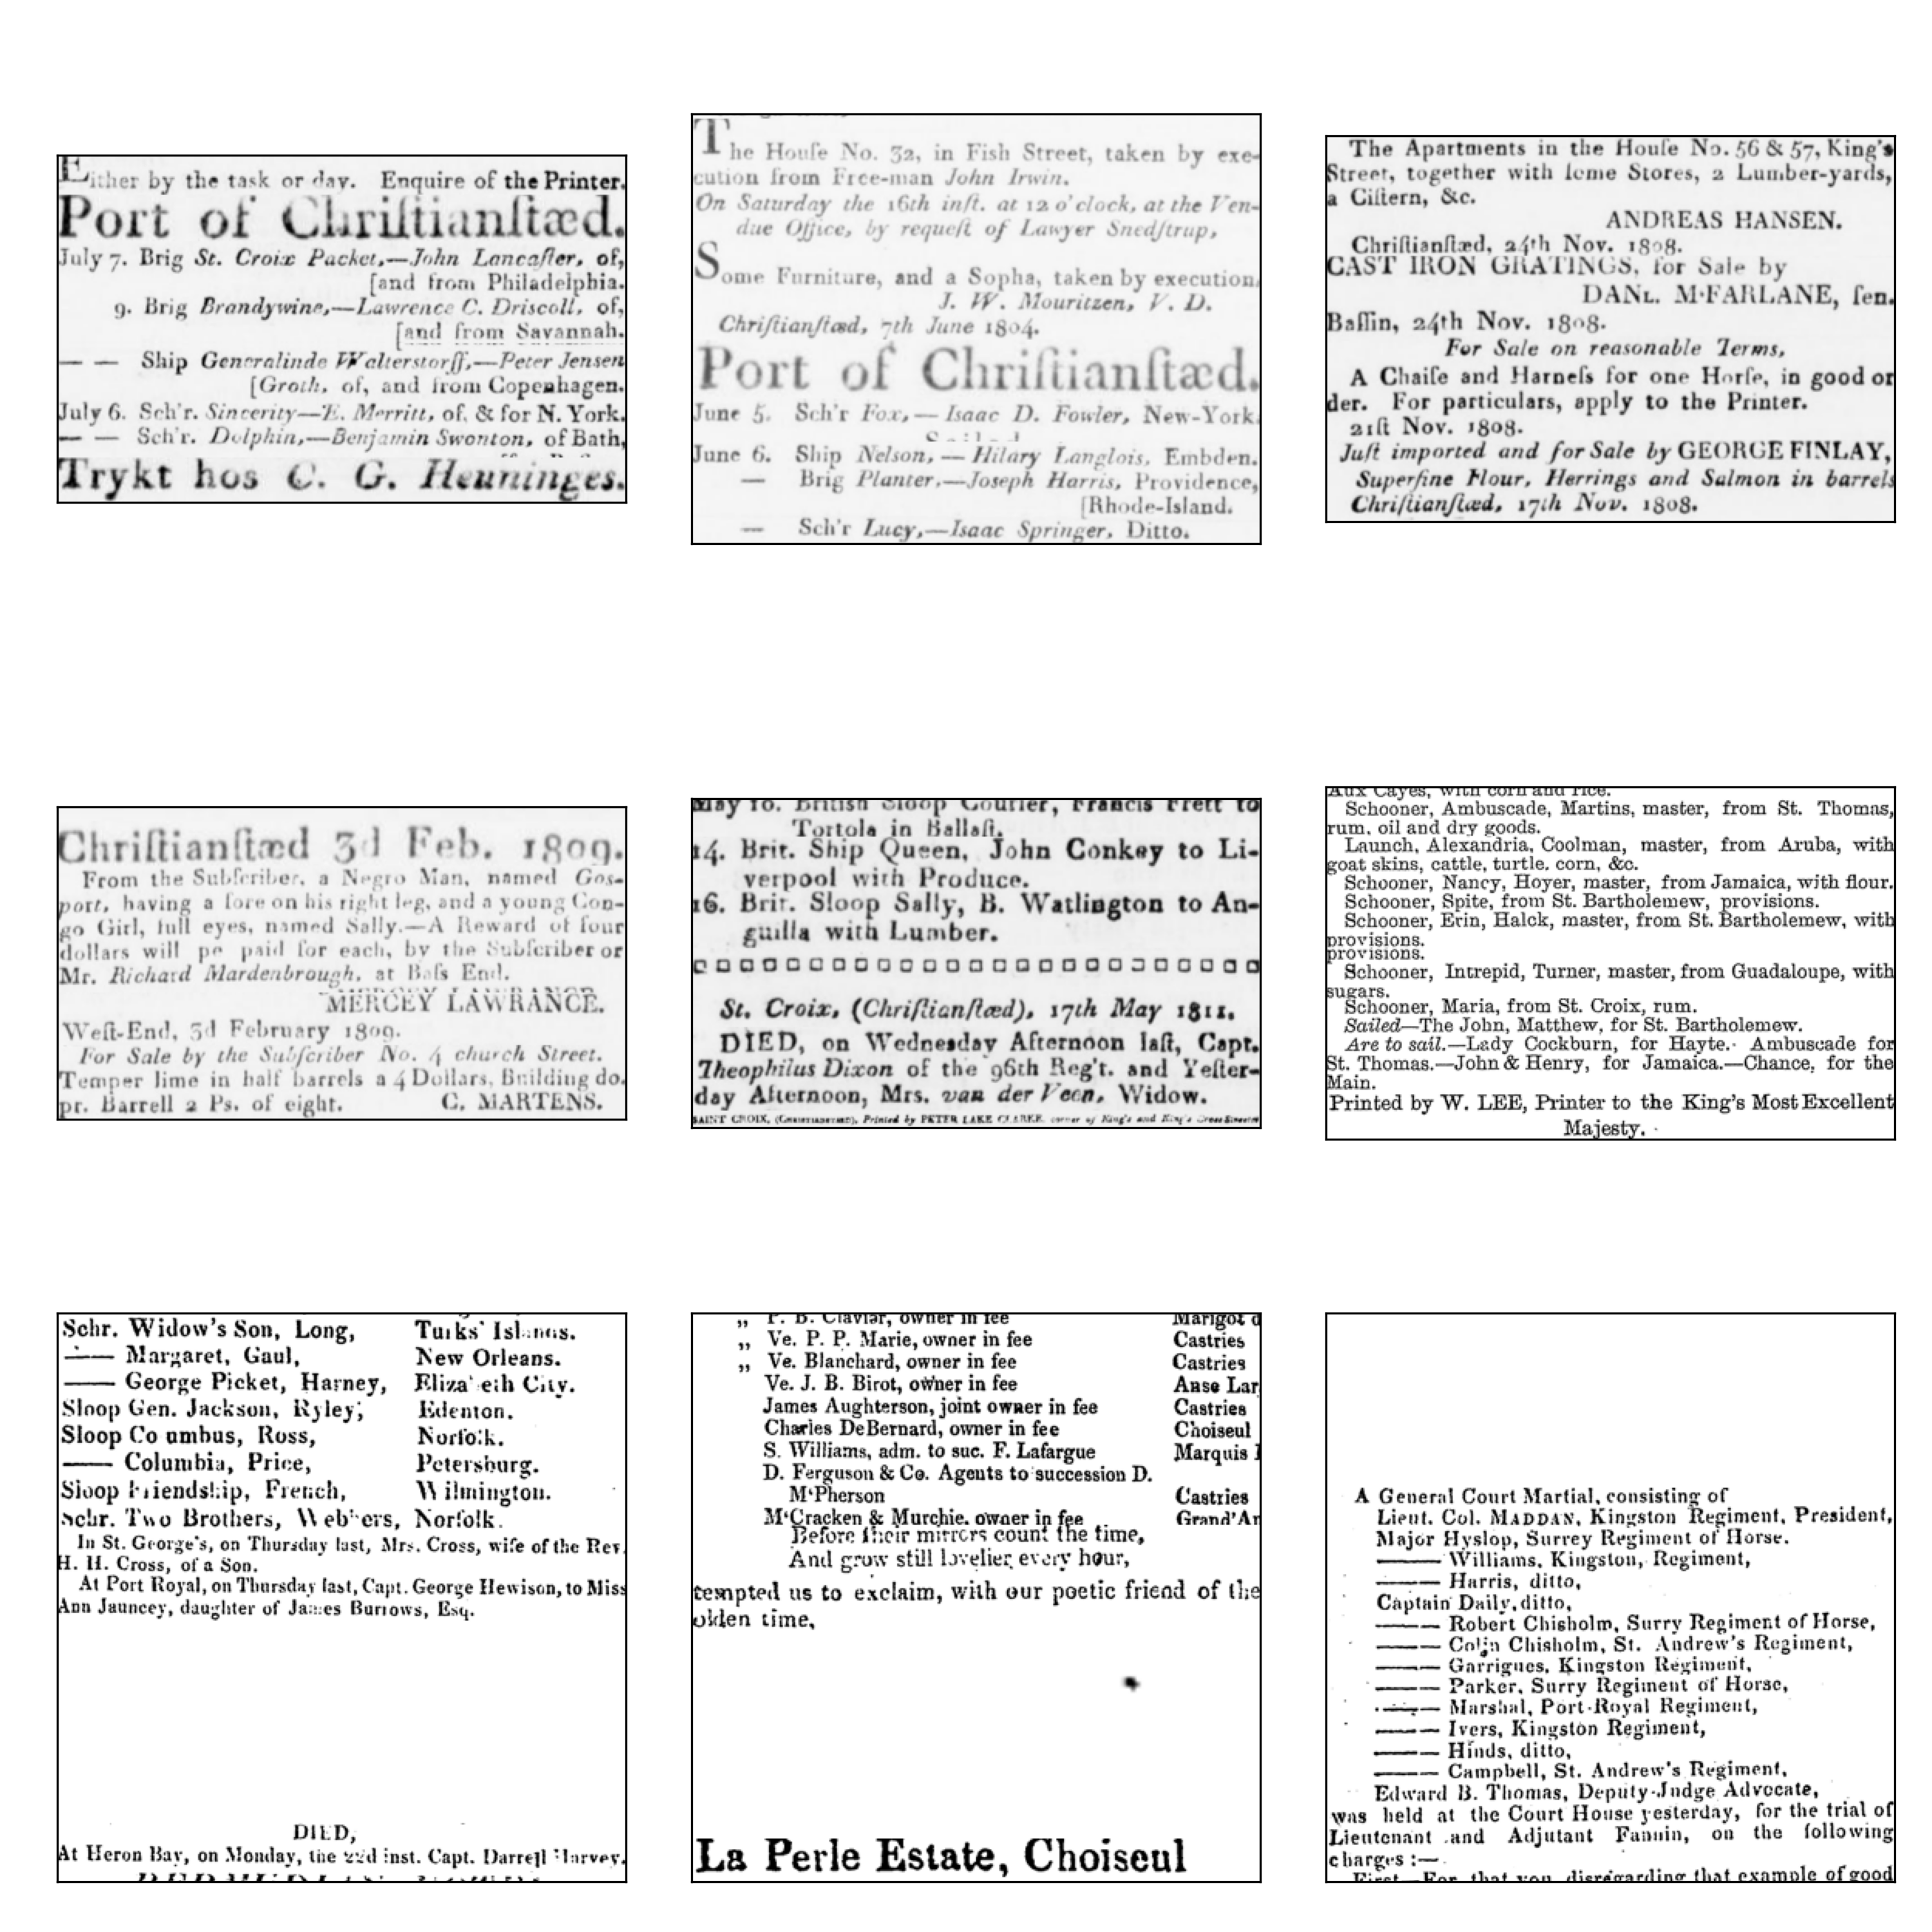

In [132]:
import math
import matplotlib.pyplot as plt
import io


def plot_arrays(arrays, titles=None) -> Image:
    # get the number of arrays
    n: int = len(arrays)
    # get the shape of each array
    shape: tuple = arrays[0].shape
    # compute the number of rows and columns for the grid
    rows: int = math.ceil(math.sqrt(n))
    cols: int = math.ceil(n / rows)
    # create a figure with rows x cols subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    # adjust the spacing and margins of the subplots
    fig.subplots_adjust(wspace=-100, hspace=-5)
    fig.tight_layout()
    # loop through the arrays and plot them on each subplot
    for i in range(n):
        # get the i-th array and subplot
        array: np.ndarray = arrays[i]
        # compute the row and column index for the subplot
        r: int = i // cols
        c: int = i % cols
        ax = axes[r][c]
        # plot the array as an image
        if len(shape) == 2:
            ax.imshow(array, cmap="gray")
        else:
            ax.imshow(array)
        # ax.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(left=False, bottom=False)
        # set the title as the index of the array
        if titles:
            ax.set_title(titles[i])
    # save the figure to a buffer
    buf = io.BytesIO()
    # fig.subplots_adjust(top=0.95)
    fig.savefig(buf, format="png", dpi=300)
    # close the figure
    plt.close(fig)
    # create a PIL Image object from the buffer
    img = Image.open(buf)
    # return the image object
    return img

im = plot_arrays(images)
# im.save("evaluations/runaways_semantic_search_2.png")
im